In [1]:
import pandas as pd

df_train = pd.read_csv(r'C:\Users\fabri\Desktop\fin_project\env\project\data\train.csv')
df_test = pd.read_csv(r'C:\Users\fabri\Desktop\fin_project\env\project\data\test.csv')

df_train.head()


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [2]:
df_train.tail()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080
299999,299999,Under Armour,Canvas,Small,2.0,No,Yes,Backpack,Black,18.568865,26.72762


In [3]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,300000.0,149999.500000,86602.684716,0.0,74999.750000,149999.500000,224999.250000,299999.0
Compartments,300000.0,5.443590,2.890766,1.0,3.000000,5.000000,8.000000,10.0
Weight Capacity (kg),299862.0,18.029994,6.966914,5.0,12.097867,18.068614,24.002375,30.0
Price,300000.0,81.411107,39.039340,15.0,47.384620,80.956120,115.018160,150.0


In [4]:
df_train.isna().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'Compartments'}>],
       [<Axes: title={'center': 'Weight Capacity (kg)'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

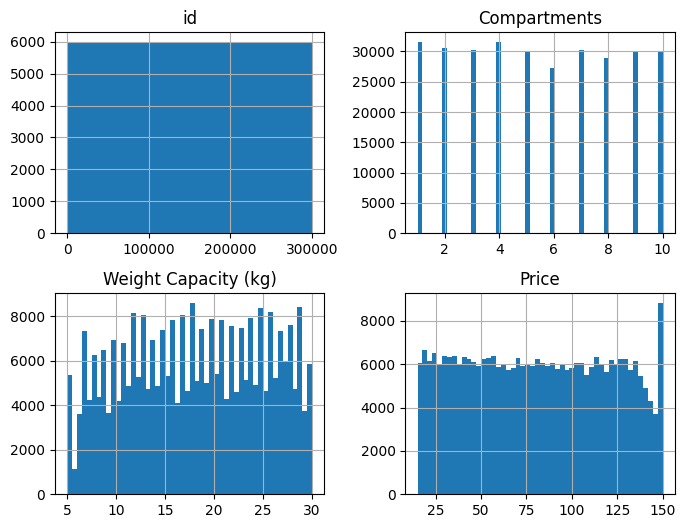

In [5]:
import matplotlib.pyplot as plt

df_train.hist(bins=50, figsize=(8,6))

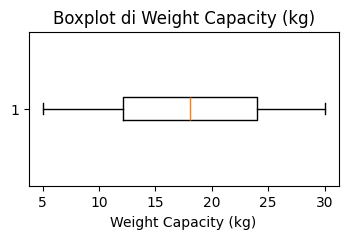

In [6]:
plt.figure(figsize=(4,2))
plt.boxplot(df_train["Weight Capacity (kg)"].dropna(), vert=False)
plt.title("Boxplot di Weight Capacity (kg)")
plt.xlabel("Weight Capacity (kg)")
plt.show()

Dato che non ci sono molti outlier è preferibile la media


In [7]:
df_train["Weight Capacity (kg)"] = df_train["Weight Capacity (kg)"].fillna(df_train["Weight Capacity (kg)"].mean())

In [8]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split


def model_based_impute(df):
    # Individua le colonne con NaN
    cols_with_nan = [col for col in df.columns if df[col].isna().any()]

    for target in cols_with_nan:
        print(f"Imputazione per: {target}")

        # Dividi i dataset
        df_complete = df[df[target].notna()].copy()
        df_missing  = df[df[target].isna()].copy()

        # X e y per l'addestramento
        X = df_complete.drop(columns=[target])
        y = df_complete[target]

        # Imputazione preliminare delle altre feature
        for c in X.select_dtypes(include='object').columns:
            X[c] = X[c].fillna('Unknown')
        for c in X.select_dtypes(include=['int', 'float']).columns:
            X[c] = X[c].fillna(X[c].median())

        # Encoding one-hot delle categoriche
        X_enc = pd.get_dummies(X, drop_first=True)

        # Scegli modello in base al tipo di target
        if y.dtype.name in ['object', 'category']:
            model = RandomForestClassifier(n_estimators=100, random_state=0)
        else:
            model = RandomForestRegressor(n_estimators=100, random_state=0)

        # Split per validazione (opzionale)
        X_train, X_val, y_train, y_val = train_test_split(
            X_enc, y, test_size=0.2, random_state=0
        )
        model.fit(X_train, y_train)

        # Valutazione
        score = model.score(X_val, y_val)
        print(f"  Score su validation set: {score:.3f}")

        # Prepara X_missing
        X_miss = df_missing.drop(columns=[target]).copy()
        for c in X_miss.select_dtypes(include='object').columns:
            X_miss[c] = X_miss[c].fillna('Unknown')
        for c in X_miss.select_dtypes(include=['int', 'float']).columns:
            X_miss[c] = X_miss[c].fillna(X_miss[c].median())
        X_miss_enc = pd.get_dummies(X_miss, drop_first=True)

        # Allinea le colonne
        X_miss_enc = X_miss_enc.reindex(columns=X_enc.columns, fill_value=0)

        # Predici e assegna
        df.loc[df[target].isna(), target] = model.predict(X_miss_enc)
        print(f"  Imputati {df_missing.shape[0]} valori di '{target}'.\n")

# Esegui l'imputazione su df_train
model_based_impute(df_train)


Imputazione per: Brand
  Score su validation set: 0.200
  Imputati 9705 valori di 'Brand'.

Imputazione per: Material
  Score su validation set: 0.265
  Imputati 8347 valori di 'Material'.

Imputazione per: Size
  Score su validation set: 0.354
  Imputati 6595 valori di 'Size'.

Imputazione per: Laptop Compartment
  Score su validation set: 0.522
  Imputati 7444 valori di 'Laptop Compartment'.

Imputazione per: Waterproof
  Score su validation set: 0.524
  Imputati 7050 valori di 'Waterproof'.

Imputazione per: Style
  Score su validation set: 0.359
  Imputati 7970 valori di 'Style'.

Imputazione per: Color
  Score su validation set: 0.197
  Imputati 9950 valori di 'Color'.



In [9]:
df_train.isna().sum()

id                      0
Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
Price                   0
dtype: int64